<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [X] Change 68% confidence interval error bars to 95% or 99.7%.
- [X] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def sigmoid_derivative(x, a, b, c):
  sigma = sigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_growth_rate_domain(growth_rate_curve, *args):
  return unp.log(growth_rate_curve(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

Province/States    Country/Region  ... 3/20/2020  3/21/2020
0         Confirmed          Globally  ...  234073.0   266073.0
1            Deaths          Globally  ...    9840.0    11184.0
2         Confirmed             China  ...   81300.0    81416.0
3         Confirmed  Outside of China  ...  152773.0   184657.0
4            Deaths             China  ...    3253.0     3261.0
..              ...               ...  ...       ...        ...
223          Deaths               NaN  ...    1312.0     1466.0
224       Confirmed               NaN  ...   13271.0    18877.0
225          Deaths               NaN  ...     178.0      235.0
226       Confirmed               NaN  ...     473.0      572.0
227          Deaths               NaN  ...       8.0       12.0

[228 rows x 64 columns]

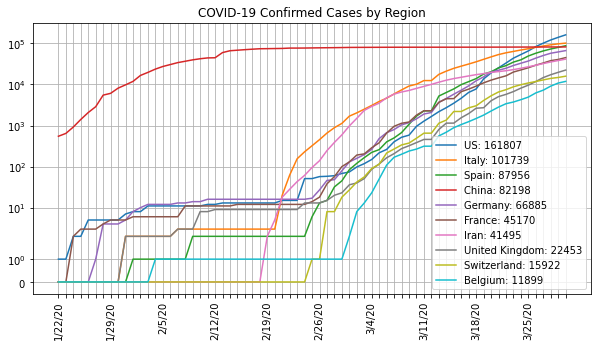

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title("COVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

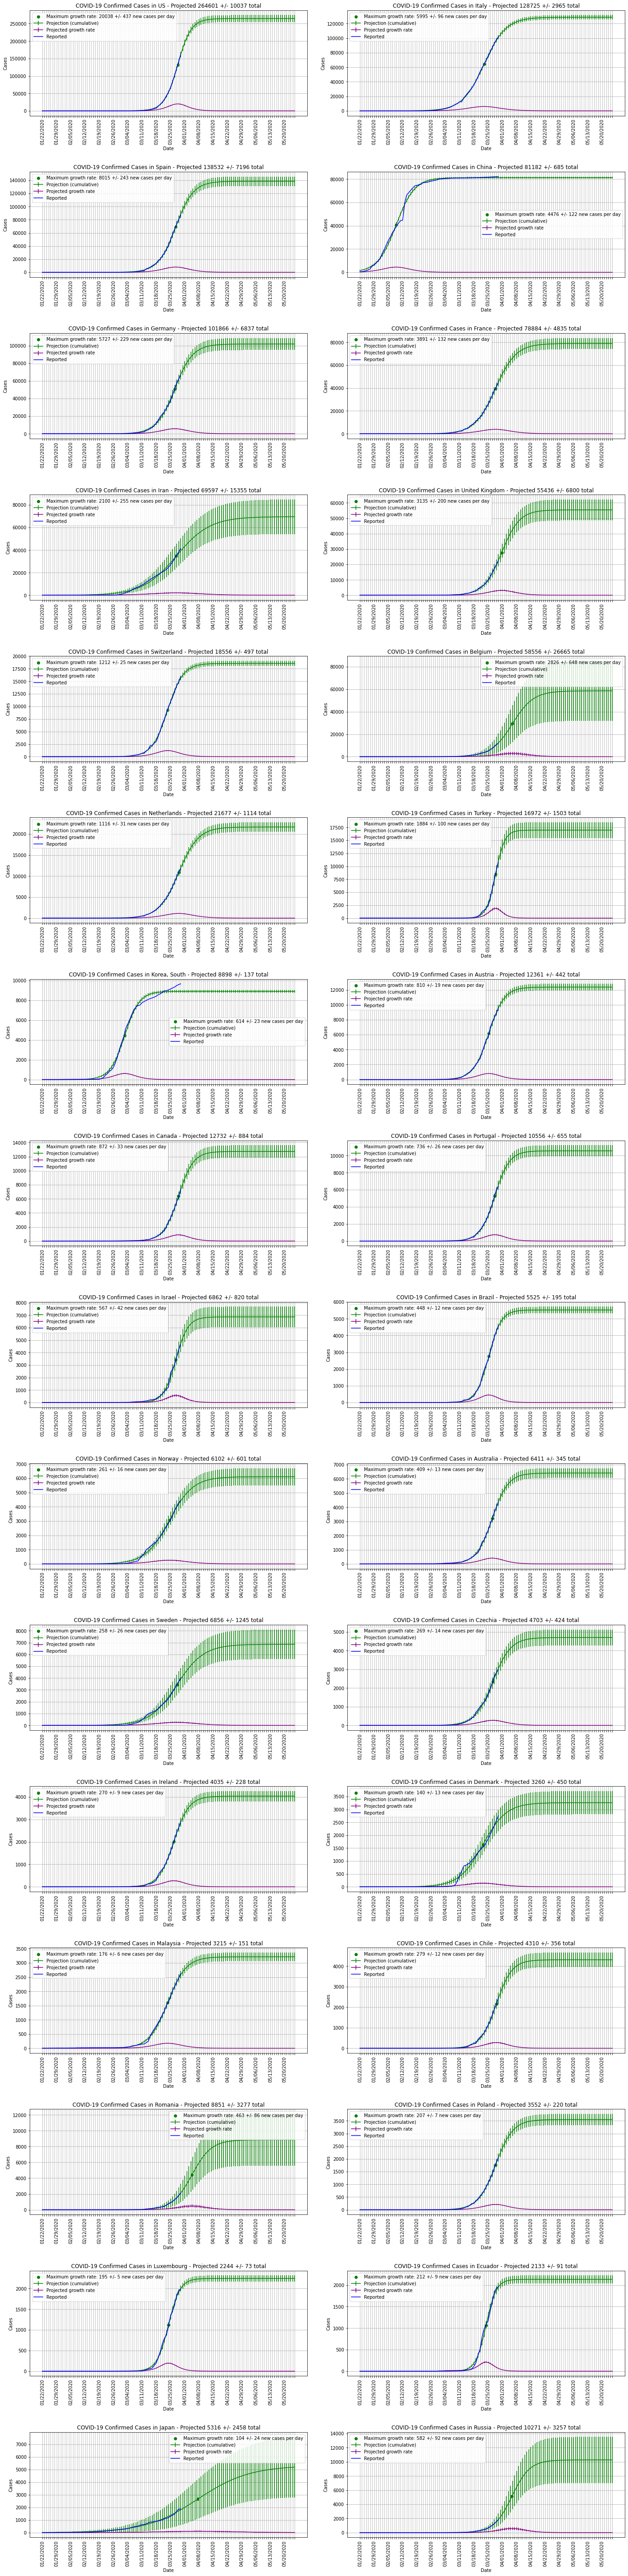

In [9]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Confirmed Cases in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev * 2)} total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

In [10]:
ts_us_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

ts_us_confirmed_df = ts_us_confirmed_df.drop(["UID", "iso2", "iso3", "code3",
                                              "FIPS", "Admin2",
                                              "Country_Region", "Lat", "Long_",
                                              "Combined_Key"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_confirmed_df

1/22/2020  1/23/2020  ...  3/29/2020  3/30/2020
Province_State                                  ...                      
New York                          0          0  ...      59648      66663
New Jersey                        0          0  ...      13386      16636
California                        0          0  ...       5852       7138
Michigan                          0          0  ...       5488       6498
Massachusetts                     0          0  ...       4955       5752
Florida                           0          0  ...       4246       5473
Illinois                          0          0  ...       4596       5056
Washington                        1          1  ...       4465       4923
Pennsylvania                      0          0  ...       3432       4155
Louisiana                         0          0  ...       3540       4025
Texas                             0          0  ...       2792       3147
Georgia                           0          0  ...       2651       2808
Connecticut                       0          0  ...       1993       2571
Colorado                          0          0  ...       2307       2311
Ohio                              0          0  ...       1653       1933
Tennessee                         0          0  ...       1720       1917
Indiana                           0          0  ...       1513       1786
Maryland                          0          0  ...       1239       1413
North Carolina                    0          0  ...       1191       1313
Wisconsin                         0          0  ...       1164       1230
Arizona                           0          0  ...        919       1157
Missouri                          0          0  ...        915       1051
Virginia                          0          0  ...        890       1020
Nevada                            0          0  ...        920       1012
South Carolina                    0          0  ...        774        925
Alabama                           0          0  ...        825        899
Mississippi                       0          0  ...        759        847
Utah                              0          0  ...        720        804
Oregon                            0          0  ...        548        606
Minnesota                         0          0  ...        503        576
Oklahoma                          0          0  ...        429        481
Kentucky                          0          0  ...        438        479
Arkansas                          0          0  ...        426        473
Iowa                              0          0  ...        336        424
Rhode Island                      0          0  ...        294        408
District of Columbia              0          0  ...        342        401
Kansas                            0          0  ...        330        372
Idaho                             0          0  ...        281        340
New Hampshire                     0          0  ...        214        314
Maine                             0          0  ...        253        275
Delaware                          0          0  ...        232        264
Vermont                           0          0  ...        235        256
New Mexico                        0          0  ...        237        237
Hawaii                            0          0  ...        149        175
Puerto Rico                       0          0  ...        127        174
Montana                           0          0  ...        154        171
West Virginia                     0          0  ...        113        145
Nebraska                          0          0  ...        108        145
Alaska                            0          0  ...        102        114
North Dakota                      0          0  ...         98        109
Grand Princess                    0          0  ...        103        103
South Dakota                      0          0  ...         90        101
Wyoming                       

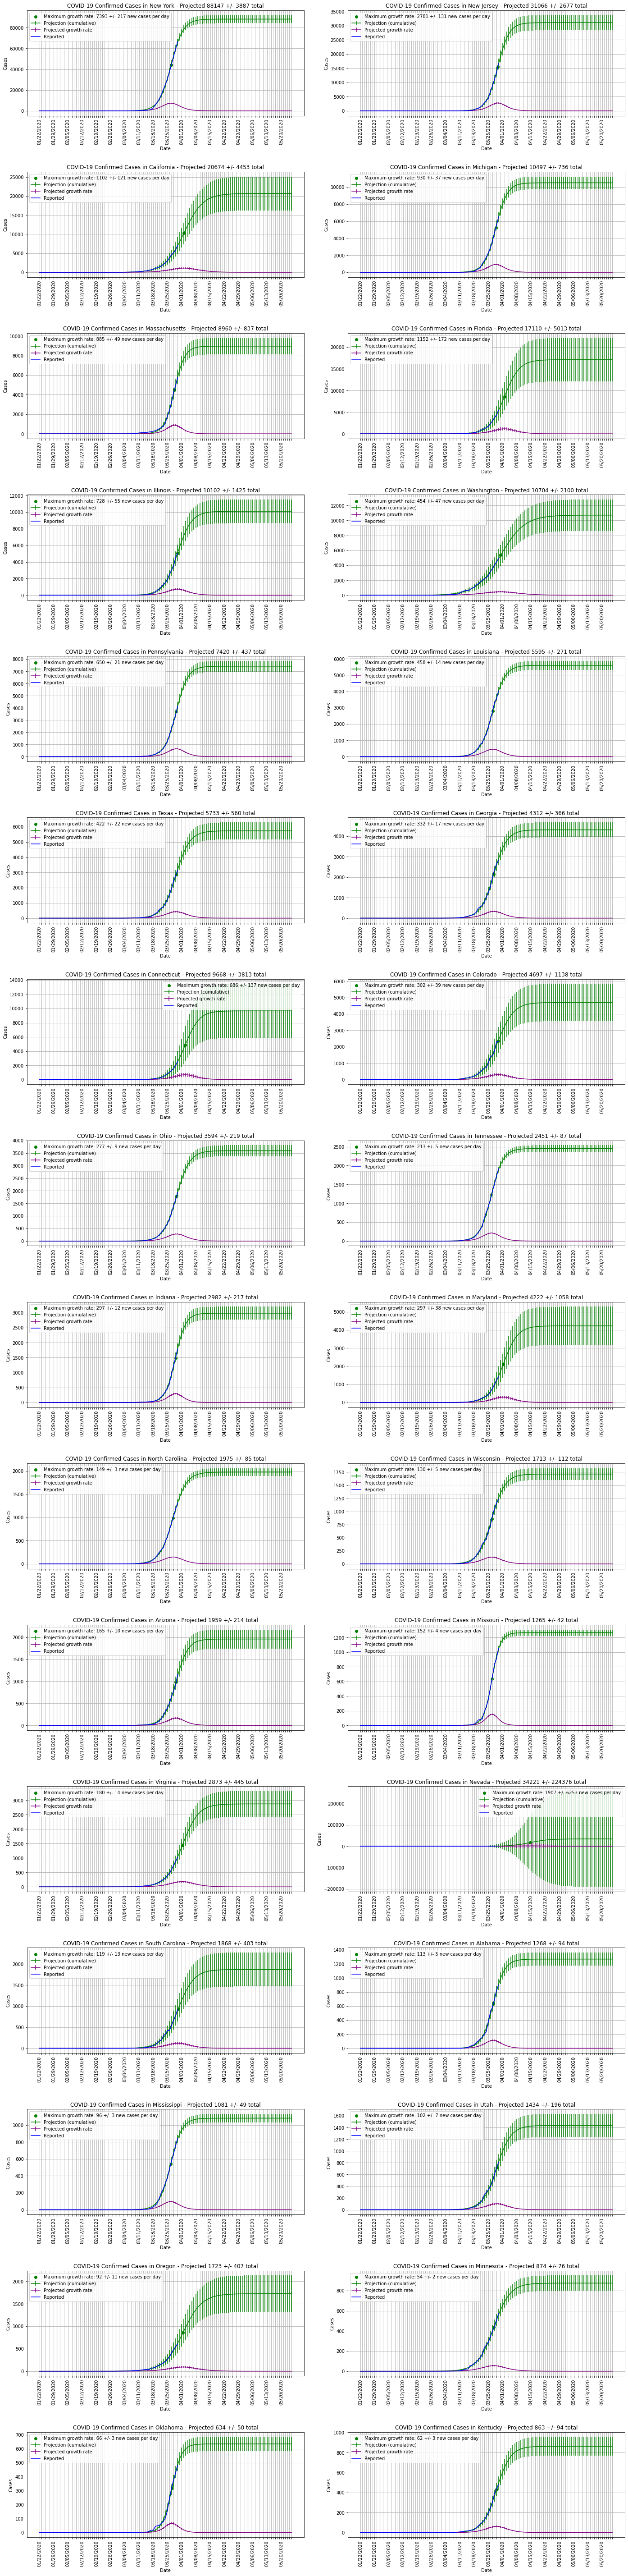

In [11]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_states, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Confirmed Cases in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev * 2)} total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

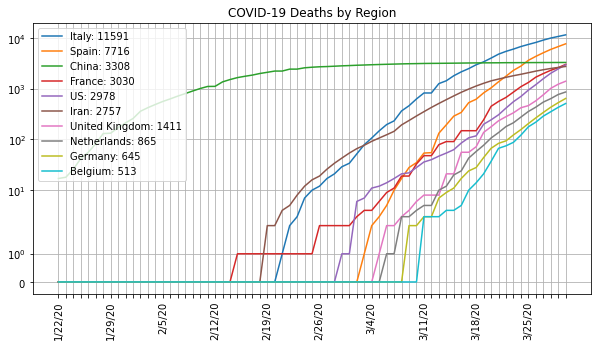

In [12]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title("COVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

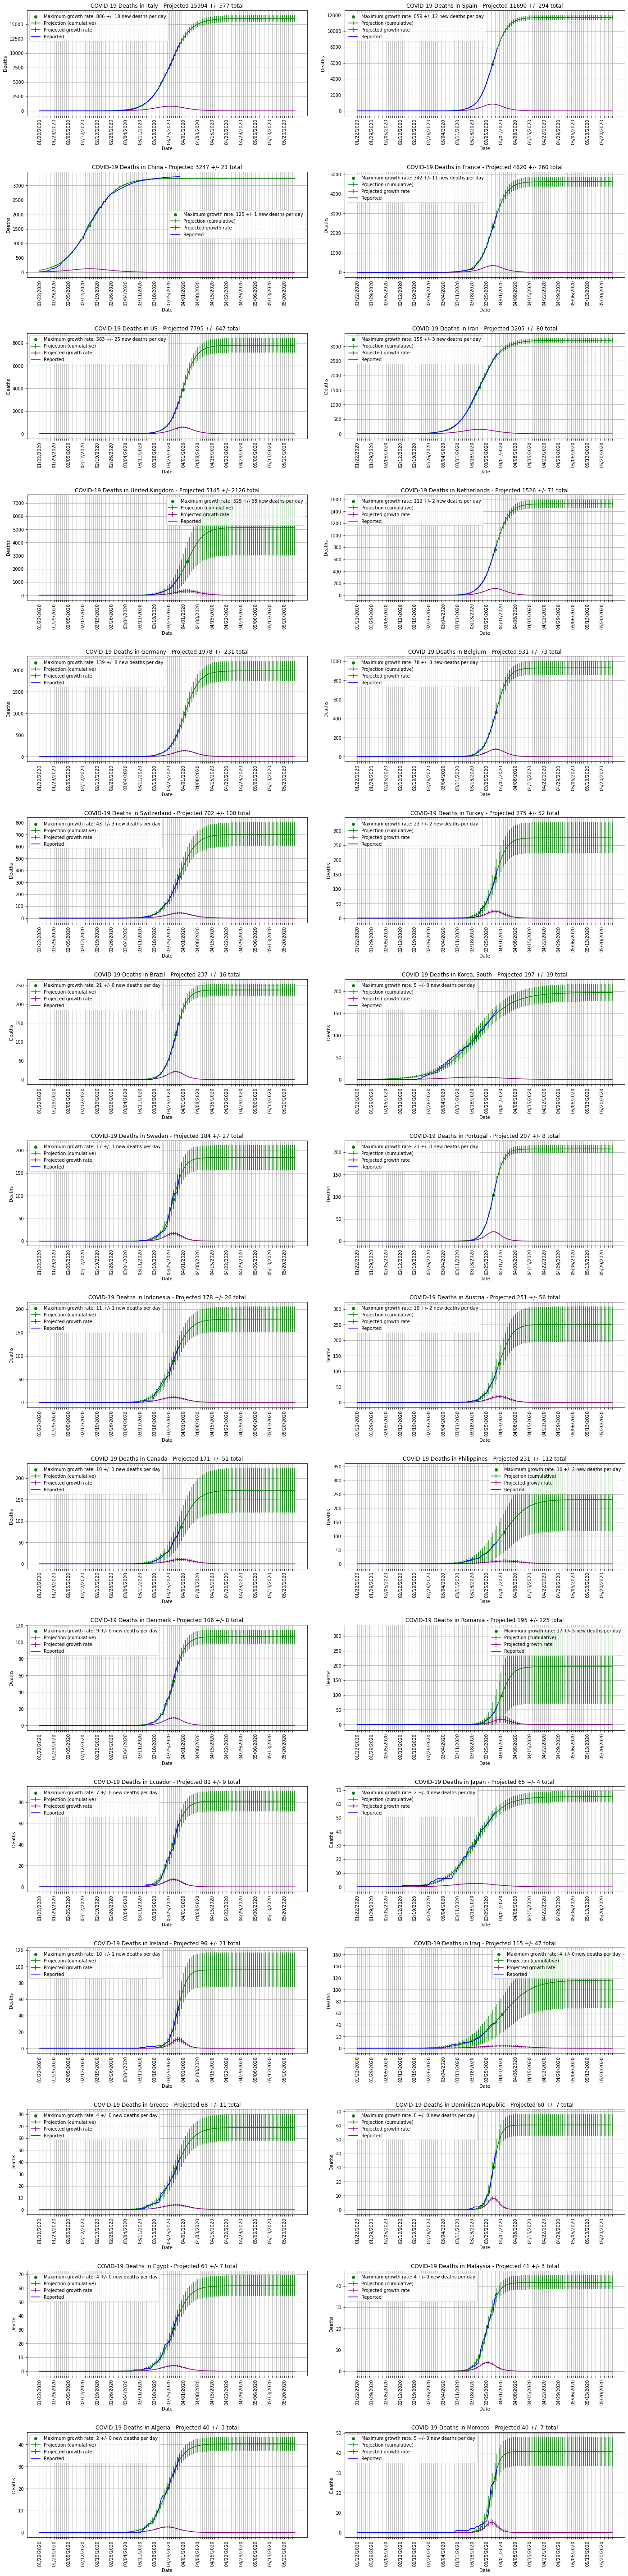

In [13]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Deaths in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev * 2)} total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

In [14]:
ts_us_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

ts_us_deaths_df = ts_us_deaths_df.drop(["UID", "iso2", "iso3", "code3",
                                           "FIPS", "Admin2",
                                           "Country_Region", "Lat", "Long_",
                                           "Combined_Key", "Population"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_deaths_df

1/22/2020  1/23/2020  ...  3/29/2020  3/30/2020
Province_State                                  ...                      
New York                          0          0  ...        965       1218
Washington                        0          0  ...        198        205
New Jersey                        0          0  ...        161        198
Louisiana                         0          0  ...        151        185
Michigan                          0          0  ...        132        184
California                        0          0  ...        124        146
Georgia                           0          0  ...         80         87
Illinois                          0          0  ...         66         73
Florida                           0          0  ...         56         63
Massachusetts                     0          0  ...         48         56
Pennsylvania                      0          0  ...         41         50
Colorado                          0          0  ...         47         47
Texas                             0          0  ...         37         45
Ohio                              0          0  ...         29         40
Connecticut                       0          0  ...         34         36
Indiana                           0          0  ...         32         35
Arizona                           0          0  ...         17         20
Wisconsin                         0          0  ...         18         20
South Carolina                    0          0  ...         16         18
Mississippi                       0          0  ...         14         16
Oklahoma                          0          0  ...         16         16
Oregon                            0          0  ...         13         16
Nevada                            0          0  ...         15         15
Maryland                          0          0  ...         10         15
Virginia                          0          0  ...         20         15
Tennessee                         0          0  ...          8         14
Missouri                          0          0  ...         13         13
Vermont                           0          0  ...         12         12
Kentucky                          0          0  ...          9         11
Alabama                           0          0  ...         10         10
Minnesota                         0          0  ...          9         10
District of Columbia              0          0  ...          5          9
Kansas                            0          0  ...          7          8
Arkansas                          0          0  ...          6          7
North Carolina                    0          0  ...          7          7
Puerto Rico                       0          0  ...          3          6
Delaware                          0          0  ...          6          6
Idaho                             0          0  ...          5          6
Iowa                              0          0  ...          4          6
Montana                           0          0  ...          1          5
Rhode Island                      0          0  ...          3          4
Utah                              0          0  ...          2          4
New Hampshire                     0          0  ...          2          3
Maine                             0          0  ...          3          3
Grand Princess                    0          0  ...          3          3
Alaska                            0          0  ...          2          3
New Mexico                        0          0  ...          2          2
Nebraska                          0          0  ...          2          2
North Dakota                      0          0  ...          1          2
Guam                              0          0  ...          1          1
South Dakota                      0          0  ...          1          1
West Virginia                     0          0  ...          0          1
American Samoa                

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


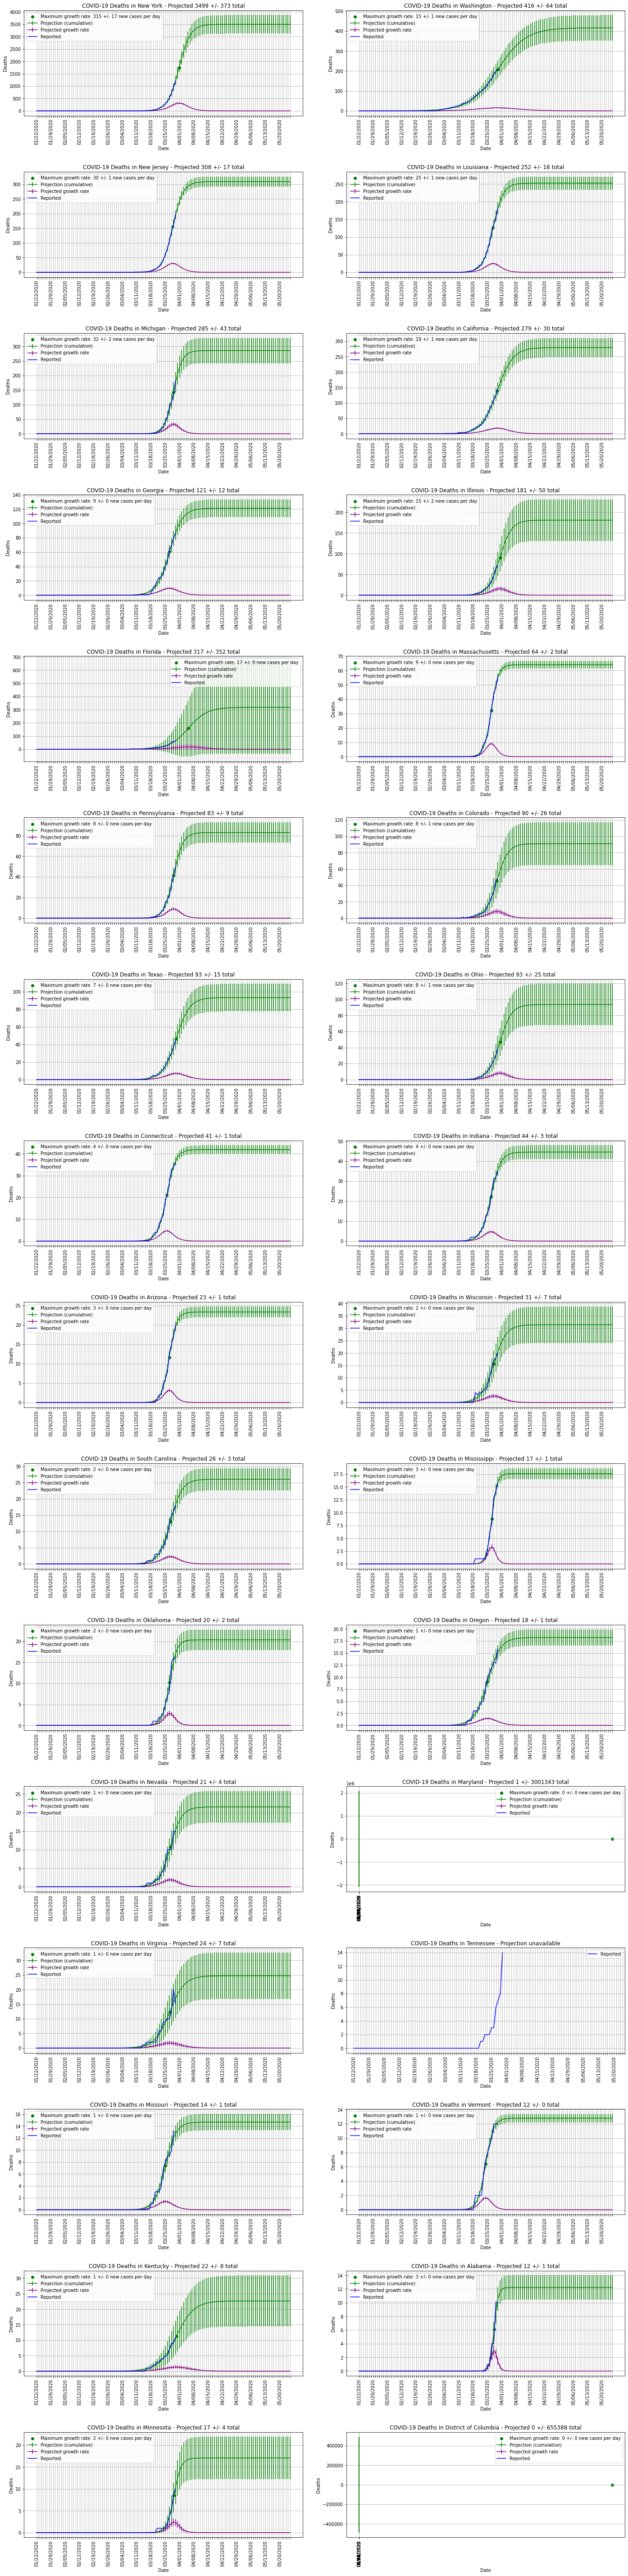

In [15]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_states, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"COVID-19 Deaths in {region} - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev * 2)} total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} +/- {int(inflection_y.std_dev)} new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

In [16]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20       17
1/23/20       18
1/24/20       26
1/25/20       42
1/26/20       56
           ...  
3/26/20    23970
3/27/20    27198
3/28/20    30652
3/29/20    33925
3/30/20    37582
Length: 69, dtype: object

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


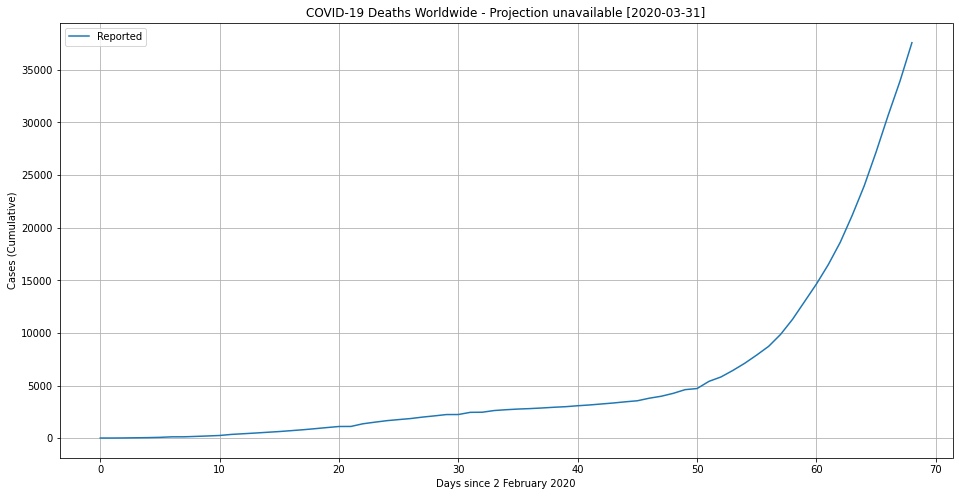

In [17]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"COVID-19 Deaths Worldwide - {'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} +/- {int(u_popt[1].std_dev * 2)} total'} [{date.today()}]")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()